# Hybrid EV Spare Parts Demand Classification
_Final consolidated script (ANN + benchmarks) with all edits applied_


# Imports & Reproducibility


In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
import subprocess
import platform

def _ensure_import(module_name, pip_name=None):
    try:
        return __import__(module_name)
    except ModuleNotFoundError:
        pkg = pip_name or module_name
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg, '-q'])
        return __import__(module_name)

_ensure_import('seaborn', 'seaborn')
_ensure_import('sklearn', 'scikit-learn')
_ensure_import('joblib', 'joblib')
_ensure_import('numpy', 'numpy')
_ensure_import('pandas', 'pandas')
_ensure_import('matplotlib', 'matplotlib')
system = platform.system()
machine = platform.machine().lower()
tf_pkg = 'tensorflow'
if system == 'Windows':
    tf_pkg = 'tensorflow-cpu'
elif system == 'Darwin' and 'arm' in machine:
    tf_pkg = 'tensorflow-macos'
_ensure_import('tensorflow', tf_pkg)



import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"

import json
import itertools
import hashlib
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupShuffleSplit, GroupKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, f1_score
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.utils.class_weight import compute_class_weight

import joblib

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Seeds
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)



# Config


In [2]:
# Exclude 'part' from features (still used for grouping)
DROP_PART = True

# ANN hyperparameter grid (exhaustive but small)
GRID = {
    'num_layers':    [1, 2, 3],
    'units':         [16, 32],
    'dropout_rate':  [0.0, 0.2],
    'l2_reg':        [0.0, 1e-4],
    'learning_rate': [1e-3, 3e-3, 1e-2]
}

# Small grids for the classical models
GRIDS_CLASSIC = {
    "svc_rbf": {"C": [1.0, 3.0], "gamma": ["scale", "auto"]},
    "logreg":  {"C": [0.3, 1.0, 3.0], "solver": ["lbfgs"], "max_iter": [2000]},
    "et":      {"n_estimators": [200, 400], "max_depth": [None, 20]},
    "sgd":     {"loss": ["log_loss"], "alpha": [1e-4, 1e-3], "max_iter": [2000], "random_state": [SEED]},
    "lda":     {"solver": ["svd"]},
}

MODEL_ZOO = {
    "svc_rbf": {
        "label": "SVC (RBF)",
        "factory": lambda p: SVC(**p),
        "style": "scale",
    },
    "logreg": {
        "label": "LogisticRegression",
        "factory": lambda p: LogisticRegression(multi_class="multinomial", **p),
        "style": "scale",
    },
    "et": {
        "label": "ExtraTrees",
        "factory": lambda p: ExtraTreesClassifier(random_state=SEED, n_jobs=-1, **p),
        "style": "tree",
    },
    "sgd": {
        "label": "SGDClassifier (log_loss)",
        "factory": lambda p: SGDClassifier(**p),
        "style": "scale",
    },
    "lda": {
        "label": "LinearDiscriminantAnalysis",
        "factory": lambda p: LDA(**p),
        "style": "scale",
    },
}
MODEL_KEYS = ["svc_rbf", "logreg", "et", "sgd", "lda"]



# Load & clean


In [3]:
# Support environment override, then common relative paths
data_env = os.environ.get("DEMAND_DATA_PATH", "").strip()
candidates = [Path(p) for p in [data_env] if p] + [
    Path("data") / "demand.csv",
    Path("..") / "data" / "demand.csv",
]
file_path = None
for p in candidates:
    if p.exists():
        file_path = p
        break
if file_path is None:
    raise FileNotFoundError("Could not find demand.csv. Set DEMAND_DATA_PATH or place the file in data/ or ../data/.")

df = pd.read_csv(file_path)
df.columns = df.columns.str.strip()
print("Using file:", file_path.resolve())
print("Initial shape:", df.shape)

# Drop exact duplicates
dup_count = df.duplicated().sum()
if dup_count:
    print(f"Dropping {dup_count} duplicate rows")
    df = df.drop_duplicates().reset_index(drop=True)



Using file: /Users/yaeesh/hev-spareparts-ml/data/demand.csv
Initial shape: (7652, 16)
Dropping 60 duplicate rows


# Feature schema


In [4]:
# Keep the exact strings as present in your CSV.
cat_cols = [
    'car type',
    'made in',
    'original/imitator',
    'new\\used',
    'selling location',
    'service location (repair shop/automotive company',
    'part'  # identity-like
]
num_all = [
    'number of cars in jordan',
    'car age',
    'failure rate',
    'price of the car',
    'repair or replacement cost',
    'critically',                         # ensure this matches the CSV header
    'on line price',
    'car total maintenance cost average'  # numeric
]

required_cols = cat_cols + num_all + ['demand']
missing_cols = [c for c in required_cols if c not in df.columns]
if missing_cols:
    raise ValueError(f"Missing expected columns: {missing_cols}")

cat_cols_effective = [c for c in cat_cols if not (DROP_PART and c == 'part')]
X_all = df[cat_cols_effective + num_all].copy()
groups_all = df['part'].astype(str)  # for grouped splits

# Numeric columns that benefit from log1p
skewed_cols = [
    'on line price',
    'number of cars in jordan',
    'failure rate',
    'repair or replacement cost',
    'critically',
    'price of the car'
]
other_num_cols = [c for c in num_all if c not in skewed_cols]



# Helper functions


In [5]:
def compute_thresholds_from_train(demand_series, q_low=0.33, q_high=0.66):
    q = demand_series.quantile([q_low, q_high])
    return float(q.loc[q_low]), float(q.loc[q_high])

def bin_with_thresholds(demand_series, low_thr, high_thr):
    # Note: pd.cut ties at exact quantiles fall into the higher bin by default
    return pd.cut(
        demand_series,
        bins=[-np.inf, low_thr, high_thr, np.inf],
        labels=[0, 1, 2]
    ).astype(int)

def make_preprocessor(style: str) -> ColumnTransformer:
    """Return a ColumnTransformer adapted to the model style."""
    if style == "scale":
        num_skew = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('log1p', FunctionTransformer(np.log1p, validate=False)),
            ('scaler', StandardScaler())
        ])
        num_plain = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
    elif style == "tree":
        num_skew = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('log1p', FunctionTransformer(np.log1p, validate=False))
        ])  # no scaler
        num_plain = Pipeline([
            ('imputer', SimpleImputer(strategy='median'))
        ])
    else:
        raise ValueError(f"Unknown preprocessor style: {style}")

    # OHE dense for compatibility across versions
    try:
        cat = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])
    except TypeError:
        cat = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
        ])

    return ColumnTransformer(
        transformers=[
            ('num_skew', num_skew,   skewed_cols),
            ('num',      num_plain,  other_num_cols),
            ('cat',      cat,        cat_cols_effective)
        ],
        remainder='drop'
    )

def build_ann(input_dim, num_layers, units, dropout_rate, l2_reg, learning_rate, num_classes=3):
    tf.keras.backend.clear_session()
    model = Sequential()
    reg = regularizers.l2(l2_reg) if l2_reg and l2_reg > 0 else None
    for i in range(num_layers):
        if i == 0:
            model.add(Dense(units, activation='relu', kernel_regularizer=reg, input_shape=(input_dim,)))
        else:
            model.add(Dense(units, activation='relu', kernel_regularizer=reg))
        if dropout_rate and dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def grid_dict_product(grid):
    keys = list(grid.keys())
    for values in itertools.product(*(grid[k] for k in keys)):
        yield dict(zip(keys, values))

def hash_rows(df_like):
    """Create a stable hash per row using the actual feature columns used by the model."""
    str_df = df_like.copy()
    for c in str_df.columns:
        if pd.api.types.is_float_dtype(str_df[c]) or pd.api.types.is_integer_dtype(str_df[c]):
            str_df[c] = str_df[c].astype(float).map(lambda x: f"{x:.12g}")
        else:
            str_df[c] = str_df[c].astype(str)
    concat = str_df.apply(lambda r: '||'.join(r.values.astype(str)), axis=1)
    return concat.map(lambda s: hashlib.md5(s.encode('utf-8')).hexdigest())



# Basic dataset profile


In [6]:
print("n_rows:", len(df), "n_unique_parts:", df['part'].nunique())
print("Rows per part (describe):")
print(df['part'].value_counts().describe())



n_rows: 7592 n_unique_parts: 36
Rows per part (describe):
count     36.000000
mean     210.888889
std       59.474738
min       40.000000
25%      188.000000
50%      188.000000
75%      235.500000
max      340.000000
Name: count, dtype: float64


# Per-part purity (leakage hint)


In [7]:
tmp_low, tmp_high = compute_thresholds_from_train(df['demand'])  # approximate
tmp_y = bin_with_thresholds(df['demand'], tmp_low, tmp_high)
part_class_counts = pd.crosstab(df['part'], tmp_y)
part_purity = part_class_counts.max(axis=1) / part_class_counts.sum(axis=1)
print("\nPer-part purity, top 10:")
print(part_purity.sort_values(ascending=False).head(10))
print(f"Mean per-part purity: {part_purity.mean():.4f}")




Per-part purity, top 10:
part
2     1.000000
1     0.900000
29    0.829787
6     0.796748
24    0.739130
36    0.702128
18    0.659574
20    0.609524
10    0.608696
15    0.595745
dtype: float64
Mean per-part purity: 0.5293


# Outer grouped train/test split


In [8]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_idx, test_idx = next(gss.split(X_all, None, groups=groups_all))

X_train_raw, X_test_raw = X_all.iloc[train_idx], X_all.iloc[test_idx]
groups_train, groups_test = groups_all.iloc[train_idx], groups_all.iloc[test_idx]
demand_train, demand_test = df['demand'].iloc[train_idx], df['demand'].iloc[test_idx]

# Create labels using thresholds from TRAIN ONLY
low_thr, high_thr = compute_thresholds_from_train(demand_train)
print(f"\nTrain-only thresholds: 33%={low_thr:.6f}, 66%={high_thr:.6f}")
y_train = bin_with_thresholds(demand_train, low_thr, high_thr)
y_test  = bin_with_thresholds(demand_test,  low_thr, high_thr)

# Class distribution check
print("\nClass distribution (train):")
print(y_train.value_counts().sort_index())
print("Class distribution (test):")
print(y_test.value_counts().sort_index())




Train-only thresholds: 33%=1.800064, 66%=5.589000

Class distribution (train):
demand
0    1917
1    1861
2    1942
Name: count, dtype: int64
Class distribution (test):
demand
0    636
1    632
2    604
Name: count, dtype: int64


# Row-hash overlap audit


In [9]:
train_hash = hash_rows(X_train_raw)
test_hash  = hash_rows(X_test_raw)
overlap = set(train_hash).intersection(set(test_hash))
print(f"\nRow-hash overlap between train and test using model features: {len(overlap)} rows")
if len(overlap) > 0:
    print("WARNING: Identical feature rows detected across train and test. Investigate potential duplicates.")




Row-hash overlap between train and test using model features: 0 rows


# ANN grid search on grouped inner split


In [10]:
# Carve inner validation from outer training (grouped)
inner_gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
inner_tr_idx, inner_val_idx = next(inner_gss.split(X_train_raw, y_train, groups=groups_train))
X_inner_tr_raw = X_train_raw.iloc[inner_tr_idx]
X_inner_val_raw = X_train_raw.iloc[inner_val_idx]
y_inner_tr = y_train.iloc[inner_tr_idx]
y_inner_val = y_train.iloc[inner_val_idx]

# Fit ONE preprocessor for the inner split and reuse its matrices across grid combos
pre_gs = make_preprocessor(style="scale")
X_inner_tr = pre_gs.fit_transform(X_inner_tr_raw)
X_inner_val = pre_gs.transform(X_inner_val_raw)
input_dim_inner = X_inner_tr.shape[1]

best_cfg = None
best_val_f1 = -np.inf
best_history = None

total_combos = int(np.prod([len(v) for v in GRID.values()]))
print(f"\nStarting ANN exhaustive grid search over {total_combos} combinations...")
for idx, cfg in enumerate(grid_dict_product(GRID), start=1):
    print(f"Config {idx}/{total_combos}: {cfg}")
    model = build_ann(
        input_dim=input_dim_inner,
        num_layers=cfg['num_layers'],
        units=cfg['units'],
        dropout_rate=cfg['dropout_rate'],
        l2_reg=cfg['l2_reg'],
        learning_rate=cfg['learning_rate'],
        num_classes=3
    )
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=0)

    history = model.fit(
        X_inner_tr, y_inner_tr,
        epochs=200,
        validation_data=(X_inner_val, y_inner_val),
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )

    y_val_pred = np.argmax(model.predict(X_inner_val, verbose=0), axis=1)
    f1 = f1_score(y_inner_val, y_val_pred, average='macro')
    if f1 > best_val_f1:
        best_val_f1 = f1
        best_cfg = cfg
        best_history = history

print("\nBest ANN grid configuration (inner grouped val macro F1):", round(best_val_f1, 4))
print(best_cfg)




Starting ANN exhaustive grid search over 72 combinations...
Config 1/72: {'num_layers': 1, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.001}


2025-09-20 22:53:26.552178: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-09-20 22:53:26.552533: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 2/72: {'num_layers': 1, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.003}


2025-09-20 22:54:04.001104: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:54:04.001419: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 3/72: {'num_layers': 1, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.01}


2025-09-20 22:54:09.595649: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:54:09.596027: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 4/72: {'num_layers': 1, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.001}


2025-09-20 22:54:28.498071: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:54:28.498359: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 5/72: {'num_layers': 1, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.003}


2025-09-20 22:54:34.401839: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:54:34.402146: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 6/72: {'num_layers': 1, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.01}


2025-09-20 22:54:41.799567: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:54:41.799902: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 7/72: {'num_layers': 1, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.001}


2025-09-20 22:54:51.712857: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:54:51.713190: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 8/72: {'num_layers': 1, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.003}


2025-09-20 22:55:00.132195: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:55:00.132527: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 9/72: {'num_layers': 1, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.01}
Config 10/72: {'num_layers': 1, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.001}


2025-09-20 22:55:16.047149: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:55:16.047889: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 11/72: {'num_layers': 1, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.003}


2025-09-20 22:55:23.230309: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:55:23.230684: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 12/72: {'num_layers': 1, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.01}


2025-09-20 22:55:29.011327: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:55:29.011685: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 13/72: {'num_layers': 1, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.001}


2025-09-20 22:55:38.923796: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:55:38.924139: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 14/72: {'num_layers': 1, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.003}


2025-09-20 22:55:44.087931: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:55:44.088251: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 15/72: {'num_layers': 1, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.01}
Config 16/72: {'num_layers': 1, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.001}


2025-09-20 22:56:01.517081: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:56:01.517411: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 17/72: {'num_layers': 1, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.003}


2025-09-20 22:56:20.526172: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:56:20.526473: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 18/72: {'num_layers': 1, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.01}


2025-09-20 22:56:25.733459: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:56:25.733752: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 19/72: {'num_layers': 1, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.001}


2025-09-20 22:56:35.160350: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:56:35.160674: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 20/72: {'num_layers': 1, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.003}


2025-09-20 22:56:41.159639: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:56:41.159966: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 21/72: {'num_layers': 1, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.01}


2025-09-20 22:56:47.772919: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:56:47.773377: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 22/72: {'num_layers': 1, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.001}


2025-09-20 22:56:55.389900: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:56:55.390237: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 23/72: {'num_layers': 1, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.003}


2025-09-20 22:57:03.326501: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:57:03.326809: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 24/72: {'num_layers': 1, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.01}
Config 25/72: {'num_layers': 2, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.001}


2025-09-20 22:57:13.503435: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:57:13.503756: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 26/72: {'num_layers': 2, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.003}


2025-09-20 22:57:21.610473: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:57:21.610784: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 27/72: {'num_layers': 2, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.01}
Config 28/72: {'num_layers': 2, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.001}


2025-09-20 22:57:29.641799: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:57:29.642129: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 29/72: {'num_layers': 2, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.003}
Config 30/72: {'num_layers': 2, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.01}


2025-09-20 22:57:37.541264: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:57:37.541592: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 31/72: {'num_layers': 2, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.001}
Config 32/72: {'num_layers': 2, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.003}


2025-09-20 22:57:42.643367: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-09-20 22:57:42.643756: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 33/72: {'num_layers': 2, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.01}


2025-09-20 22:57:52.887699: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:57:52.888007: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 34/72: {'num_layers': 2, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.001}


2025-09-20 22:57:59.048192: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:57:59.048482: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 35/72: {'num_layers': 2, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.003}
Config 36/72: {'num_layers': 2, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.01}


2025-09-20 22:58:04.194371: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-09-20 22:58:04.194671: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 37/72: {'num_layers': 2, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.001}


2025-09-20 22:58:09.296852: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-09-20 22:58:09.297180: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 38/72: {'num_layers': 2, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.003}


2025-09-20 22:58:16.698238: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:58:16.698572: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 39/72: {'num_layers': 2, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.01}
Config 40/72: {'num_layers': 2, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.001}


2025-09-20 22:58:26.534339: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:58:26.534642: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 41/72: {'num_layers': 2, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.003}
Config 42/72: {'num_layers': 2, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.01}


2025-09-20 22:58:33.600918: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:58:33.601264: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 43/72: {'num_layers': 2, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.001}


2025-09-20 22:58:42.004665: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:58:42.005004: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 44/72: {'num_layers': 2, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.003}


2025-09-20 22:58:48.400146: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:58:48.400473: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 45/72: {'num_layers': 2, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.01}


2025-09-20 22:58:54.289539: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:58:54.289844: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 46/72: {'num_layers': 2, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.001}


2025-09-20 22:59:02.631581: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:59:02.631920: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 47/72: {'num_layers': 2, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.003}


2025-09-20 22:59:08.599207: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:59:08.599520: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 48/72: {'num_layers': 2, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.01}


2025-09-20 22:59:14.449517: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:59:14.449852: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 49/72: {'num_layers': 3, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.001}


2025-09-20 22:59:19.592707: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:59:19.593056: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 50/72: {'num_layers': 3, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.003}
Config 51/72: {'num_layers': 3, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.01}


2025-09-20 22:59:24.712050: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-09-20 22:59:24.712391: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 52/72: {'num_layers': 3, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.001}


2025-09-20 22:59:30.037401: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-09-20 22:59:30.037794: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 53/72: {'num_layers': 3, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.003}


2025-09-20 22:59:35.207891: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-09-20 22:59:35.208252: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 54/72: {'num_layers': 3, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.01}
Config 55/72: {'num_layers': 3, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.001}


2025-09-20 22:59:50.463368: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:59:50.463667: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 56/72: {'num_layers': 3, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.003}


2025-09-20 22:59:58.652035: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 22:59:58.652411: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 57/72: {'num_layers': 3, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.01}


2025-09-20 23:00:04.718777: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 23:00:04.719087: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 58/72: {'num_layers': 3, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.001}


2025-09-20 23:00:10.102870: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 23:00:10.103227: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 59/72: {'num_layers': 3, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.003}
Config 60/72: {'num_layers': 3, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.01}


2025-09-20 23:00:15.667677: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-09-20 23:00:15.668009: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 61/72: {'num_layers': 3, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.001}
Config 62/72: {'num_layers': 3, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.003}


2025-09-20 23:00:31.391522: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-09-20 23:00:31.391846: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 63/72: {'num_layers': 3, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.01}


2025-09-20 23:00:37.773360: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 23:00:37.773729: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 64/72: {'num_layers': 3, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.001}


2025-09-20 23:00:42.778491: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 23:00:42.778786: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 65/72: {'num_layers': 3, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.003}
Config 66/72: {'num_layers': 3, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.01}


2025-09-20 23:00:50.789469: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 23:00:50.789829: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 67/72: {'num_layers': 3, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.001}


2025-09-20 23:00:57.102054: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 23:00:57.102392: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 68/72: {'num_layers': 3, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.003}


2025-09-20 23:01:03.328890: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 23:01:03.329198: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 69/72: {'num_layers': 3, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.01}


2025-09-20 23:01:08.352249: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 23:01:08.352578: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 70/72: {'num_layers': 3, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.001}


2025-09-20 23:01:16.847558: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 23:01:16.847855: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 71/72: {'num_layers': 3, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.003}


2025-09-20 23:01:22.270730: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 23:01:22.271077: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 72/72: {'num_layers': 3, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.01}

Best ANN grid configuration (inner grouped val macro F1): 0.9976
{'num_layers': 2, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.01}


2025-09-20 23:01:28.997918: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 23:01:28.998258: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

# Retrain ANN on full training set with grouped early stopping


In [11]:
# Fit ONE preprocessor on the full outer training set
preprocessor = make_preprocessor(style="scale")
X_train_proc = preprocessor.fit_transform(X_train_raw)
X_test_proc  = preprocessor.transform(X_test_raw)
input_dim = X_train_proc.shape[1]

# Early-stopping split by indexing the already-transformed matrix
inner_tr_idx2, inner_val_idx2 = next(inner_gss.split(X_train_raw, y_train, groups=groups_train))
X_tr2 = X_train_proc[inner_tr_idx2]
X_val2 = X_train_proc[inner_val_idx2]
y_tr2, y_val2 = y_train.iloc[inner_tr_idx2], y_train.iloc[inner_val_idx2]

model = build_ann(
    input_dim=input_dim,
    num_layers=best_cfg['num_layers'],
    units=best_cfg['units'],
    dropout_rate=best_cfg['dropout_rate'],
    l2_reg=best_cfg['l2_reg'],
    learning_rate=best_cfg['learning_rate'],
    num_classes=3
)

# Optional class weights if imbalance exists
class_weight = None
train_counts = y_tr2.value_counts().sort_index()
if train_counts.min() / train_counts.max() < 0.6:
    cw = compute_class_weight(class_weight='balanced', classes=np.array([0,1,2]), y=y_tr2)
    class_weight = {i: w for i, w in enumerate(cw)}
    print("Using class weights:", class_weight)

early_stop_final = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr_final  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=0)

history = model.fit(
    X_tr2, y_tr2,
    epochs=200,
    validation_data=(X_val2, y_val2),
    callbacks=[early_stop_final, reduce_lr_final],
    verbose=0,
    class_weight=class_weight
)



# Plots


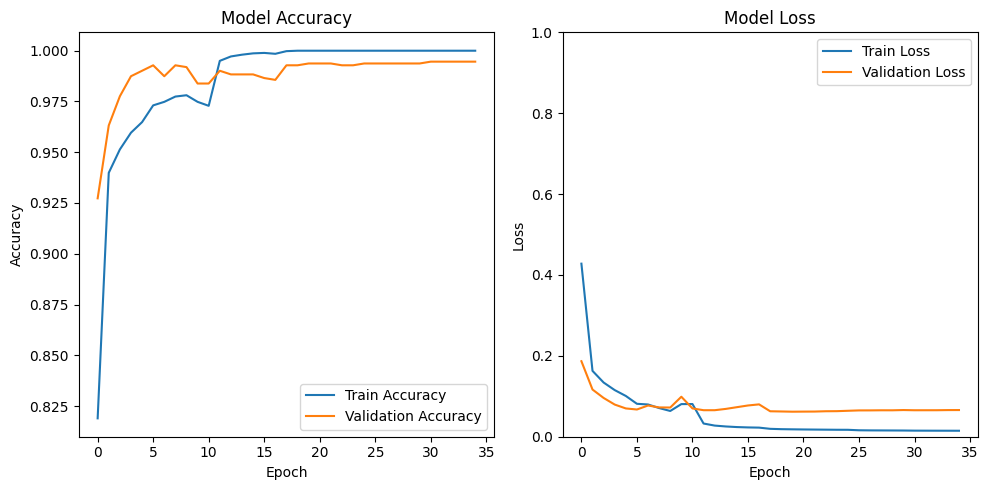

In [12]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.ylim(0, 1)
plt.title('Model Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.tight_layout()
# plt.savefig('training_validation_curves.png', dpi=300, bbox_inches='tight')
plt.show()



# Test evaluation (unseen parts)


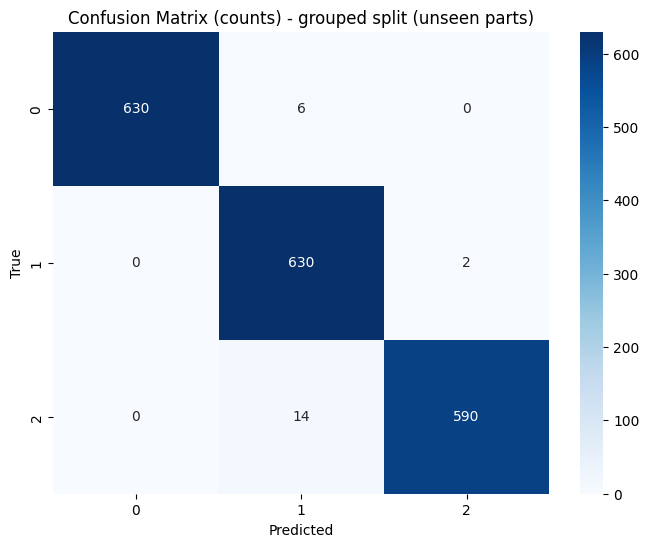


Classification Report (grouped split: unseen parts):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       636
           1       0.97      1.00      0.98       632
           2       1.00      0.98      0.99       604

    accuracy                           0.99      1872
   macro avg       0.99      0.99      0.99      1872
weighted avg       0.99      0.99      0.99      1872

Test Accuracy: 0.9882
Macro F1:      0.9882


In [13]:
y_pred_proba = model.predict(X_test_proc, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = y_test.to_numpy()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.title('Confusion Matrix (counts) - grouped split (unseen parts)')
plt.xlabel('Predicted'); plt.ylabel('True')
# plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nClassification Report (grouped split: unseen parts):")
print(classification_report(y_true, y_pred, zero_division=0))
print(f"Test Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Macro F1:      {f1_score(y_true, y_pred, average='macro'):.4f}")



# Grouped CV with per-fold thresholds & preprocessing


In [14]:
num_folds = 5
gkf = GroupKFold(n_splits=num_folds)

acc_per_fold, f1_per_fold, loss_per_fold = [], [], []
fold_no = 1
for tr_idx, val_idx in gkf.split(X_all, None, groups=groups_all):
    X_tr_raw, X_val_raw = X_all.iloc[tr_idx], X_all.iloc[val_idx]
    demand_tr, demand_val = df['demand'].iloc[tr_idx], df['demand'].iloc[val_idx]

    # Fold-specific thresholds from training portion
    low_f, high_f = compute_thresholds_from_train(demand_tr)
    y_tr_f = bin_with_thresholds(demand_tr, low_f, high_f)
    y_val_f = bin_with_thresholds(demand_val, low_f, high_f)

    pre_fold = make_preprocessor(style="scale")
    X_tr = pre_fold.fit_transform(X_tr_raw)
    X_val = pre_fold.transform(X_val_raw)

    model_fold = build_ann(
        input_dim=X_tr.shape[1],
        num_layers=best_cfg['num_layers'],
        units=best_cfg['units'],
        dropout_rate=best_cfg['dropout_rate'],
        l2_reg=best_cfg['l2_reg'],
        learning_rate=best_cfg['learning_rate'],
        num_classes=3
    )

    hist_f = model_fold.fit(
        X_tr, y_tr_f,
        epochs=200,
        validation_data=(X_val, y_val_f),
        callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
                   ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=0)],
        verbose=0
    )

    loss, acc = model_fold.evaluate(X_val, y_val_f, verbose=0)
    y_val_pred = np.argmax(model_fold.predict(X_val, verbose=0), axis=1)
    f1 = f1_score(y_val_f, y_val_pred, average='macro')

    print(f"Fold {fold_no}: Acc={acc*100:.2f}% | Loss={loss:.4f} | MacroF1={f1:.4f}")
    acc_per_fold.append(acc * 100); f1_per_fold.append(f1); loss_per_fold.append(loss)
    fold_no += 1

print('\n' + '-'*72)
print('Grouped CV summary (unseen parts each fold):')
print(f"Accuracy: mean {np.mean(acc_per_fold):.2f}%  (Â± {np.std(acc_per_fold):.2f})")
print(f"Macro F1: mean {np.mean(f1_per_fold):.4f} (Â± {np.std(f1_per_fold):.4f})")
print(f"Loss:     mean {np.mean(loss_per_fold):.4f}")
print('-'*72)



2025-09-20 23:01:34.440997: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-09-20 23:01:34.441402: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Fold 1: Acc=97.83% | Loss=0.0814 | MacroF1=0.9787


2025-09-20 23:01:48.853030: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-09-20 23:01:48.853616: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Fold 2: Acc=98.76% | Loss=0.0579 | MacroF1=0.9867
Fold 3: Acc=99.01% | Loss=0.0457 | MacroF1=0.9905


2025-09-20 23:01:54.119246: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-09-20 23:01:54.119988: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Fold 4: Acc=99.87% | Loss=0.0120 | MacroF1=0.9984
Fold 5: Acc=99.80% | Loss=0.0204 | MacroF1=0.9979

------------------------------------------------------------------------
Grouped CV summary (unseen parts each fold):
Accuracy: mean 99.05%  (Â± 0.75)
Macro F1: mean 0.9904 (Â± 0.0074)
Loss:     mean 0.0435
------------------------------------------------------------------------


2025-09-20 23:02:25.785082: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-09-20 23:02:25.785434: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

# Single-feature leakage audit (grouped CV)


In [15]:
def single_feature_cv_score(feature_name):
    # Build a tiny pipeline: transform only this feature, then multinomial logistic regression
    if feature_name in cat_cols_effective:
        try:
            ohe = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ])
        except TypeError:
            ohe = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
            ])
        pipe = Pipeline([('ohe', ohe),
                         ('clf', LogisticRegression(max_iter=2000, multi_class='multinomial'))])
        X_feat = df[[feature_name]].astype(str)
    else:
        steps = []
        steps.append(('imputer', SimpleImputer(strategy='median')))
        if feature_name in skewed_cols:
            steps.append(('log1p', FunctionTransformer(np.log1p, validate=False)))
        steps.append(('scaler', StandardScaler()))
        steps.append(('clf', LogisticRegression(max_iter=2000, multi_class='multinomial')))
        pipe = Pipeline(steps)
        X_feat = df[[feature_name]].copy()

    f1_scores = []
    for tr_idx, val_idx in gkf.split(X_all, None, groups=groups_all):
        d_tr = df['demand'].iloc[tr_idx]; d_val = df['demand'].iloc[val_idx]
        low_f, high_f = compute_thresholds_from_train(d_tr)
        y_tr_f = bin_with_thresholds(d_tr, low_f, high_f)
        y_val_f = bin_with_thresholds(d_val, low_f, high_f)

        X_tr_f = X_feat.iloc[tr_idx]; X_val_f = X_feat.iloc[val_idx]
        pipe.fit(X_tr_f, y_tr_f)
        y_val_pred = pipe.predict(X_val_f)
        f1_scores.append(f1_score(y_val_f, y_val_pred, average='macro'))

    return np.mean(f1_scores)

features_to_audit = cat_cols_effective + num_all
audit_results = []
print("\nRunning single-feature leakage audit (grouped CV, macro F1 per feature)...")
for feat in features_to_audit:
    score = single_feature_cv_score(feat)
    audit_results.append((feat, score))
audit_results.sort(key=lambda x: x[1], reverse=True)
print("Top 10 features by single-feature macro F1:")
for name, sc in audit_results[:10]:
    print(f"{name:45s} {sc:.4f}")

suspicious = [(n, s) for n, s in audit_results if s >= 0.99]
if suspicious:
    print("\nWARNING: These features alone achieve near-perfect classification under grouped CV:")
    for n, s in suspicious:
        print(f"  - {n}: macro F1 {s:.4f}")
    print("Review whether they encode target information directly or leak future knowledge.")




Running single-feature leakage audit (grouped CV, macro F1 per feature)...
Top 10 features by single-feature macro F1:
failure rate                                  0.5584
number of cars in jordan                      0.5395
price of the car                              0.3703
car age                                       0.3547
on line price                                 0.3132
repair or replacement cost                    0.3093
car type                                      0.3081
new\used                                      0.2728
selling location                              0.2643
made in                                       0.2480


# Save tuned ANN model, preprocessor, and thresholds


In [16]:
model.save("demand_clf.keras")
with open("label_thresholds.txt", "w") as f:
    f.write(f"{low_thr},{high_thr}\n")

joblib.dump(preprocessor, "preprocessor.joblib")
with open("label_metadata.json", "w") as f:
    json.dump({
        "low_thr": low_thr,
        "high_thr": high_thr,
        "class_order": [0, 1, 2],
        "seed": int(SEED),
        "cat_cols_effective": cat_cols_effective,
        "num_all": num_all,
        "skewed_cols": skewed_cols,
        "other_num_cols": other_num_cols
    }, f, indent=2)

print("\nSaved tuned ANN model to demand_clf.keras")
print("Saved train-only label thresholds to label_thresholds.txt")
print("Saved preprocessor to preprocessor.joblib and label metadata to label_metadata.json")
print("Best ANN configuration:", GRID if best_cfg is None else best_cfg)




Saved tuned ANN model to demand_clf.keras
Saved train-only label thresholds to label_thresholds.txt
Saved preprocessor to preprocessor.joblib and label metadata to label_metadata.json
Best ANN configuration: {'num_layers': 2, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.01}


# Classical models benchmark (top 5)


In [17]:
def fit_select_on_inner_classic(model_key, X_tr_raw, y_tr, groups_tr):
    """Carve an inner grouped validation split from outer-train to select hyperparams.
       Fit ONE preprocessor for that model style and reuse its matrices across param combos."""
    inner = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    inner_tr_idx, inner_val_idx = next(inner.split(X_tr_raw, y_tr, groups=groups_tr))

    X_inner_tr_raw = X_tr_raw.iloc[inner_tr_idx]
    X_inner_val_raw = X_tr_raw.iloc[inner_val_idx]
    y_inner_tr = y_tr.iloc[inner_tr_idx]
    y_inner_val = y_tr.iloc[inner_val_idx]

    spec = MODEL_ZOO[model_key]
    grid = GRIDS_CLASSIC[model_key]
    style = spec["style"]

    pre = make_preprocessor(style)
    X_inner_tr = pre.fit_transform(X_inner_tr_raw)
    X_inner_val = pre.transform(X_inner_val_raw)

    best_f1 = -np.inf
    best_params = None

    for params in grid_dict_product(grid):
        est = spec["factory"](params)
        est.fit(X_inner_tr, y_inner_tr)
        y_val_pred = est.predict(X_inner_val)
        f1 = f1_score(y_inner_val, y_val_pred, average="macro")
        if f1 > best_f1:
            best_f1 = f1
            best_params = params

    return best_params, best_f1

records = []

for key in MODEL_KEYS:
    label = MODEL_ZOO[key]["label"]
    print(f"\n=== {label} ({key}) ===")

    # Hyperparameter selection on a grouped inner split
    best_params, inner_f1 = fit_select_on_inner_classic(key, X_train_raw, y_train, groups_train)
    print(f"Selected params: {best_params} | Inner macro F1={inner_f1:.4f}")

    # Refit preprocessor on full outer-train, then train and evaluate
    pre = make_preprocessor(MODEL_ZOO[key]["style"])
    X_train_cls = pre.fit_transform(X_train_raw)
    X_test_cls  = pre.transform(X_test_raw)

    est = MODEL_ZOO[key]["factory"](best_params)
    est.fit(X_train_cls, y_train)

    y_pred_cls = est.predict(X_test_cls)
    acc = accuracy_score(y_test, y_pred_cls)
    f1m = f1_score(y_test, y_pred_cls, average="macro")

    print(f"Test Accuracy={acc:.4f} | Test Macro F1={f1m:.4f}")
    print(classification_report(y_test, y_pred_cls, zero_division=0))

    records.append(
        {
            "key": key,
            "model": label,
            "best_params": best_params,
            "inner_macro_f1": round(inner_f1, 4),
            "test_accuracy": round(acc, 4),
            "test_macro_f1": round(f1m, 4),
        }
    )




=== SVC (RBF) (svc_rbf) ===
Selected params: {'C': 3.0, 'gamma': 'auto'} | Inner macro F1=0.9646
Test Accuracy=0.9621 | Test Macro F1=0.9626
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       636
           1       0.91      0.99      0.95       632
           2       1.00      0.96      0.98       604

    accuracy                           0.96      1872
   macro avg       0.96      0.96      0.96      1872
weighted avg       0.96      0.96      0.96      1872


=== LogisticRegression (logreg) ===
Selected params: {'C': 1.0, 'solver': 'lbfgs', 'max_iter': 2000} | Inner macro F1=0.9369
Test Accuracy=0.9359 | Test Macro F1=0.9366
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       636
           1       0.88      0.94      0.91       632
           2       0.97      0.93      0.95       604

    accuracy                           0.94      1872
   macro avg       0.94      0.94  

# Summary of classical models


In [18]:
results = pd.DataFrame.from_records(records)
results_sorted = results.sort_values(
    ["test_macro_f1", "test_accuracy"], ascending=False
).reset_index(drop=True)

print("\n=== Ranked results (outer test) ===")
print(results_sorted[["model", "test_macro_f1", "test_accuracy", "inner_macro_f1", "best_params"]])

# results_sorted.to_csv("model_benchmark_results_top5.csv", index=False)
print("\nSaved benchmark table to model_benchmark_results_top5.csv")



=== Ranked results (outer test) ===
                        model  test_macro_f1  test_accuracy  inner_macro_f1  \
0                   SVC (RBF)         0.9626         0.9621          0.9646   
1          LogisticRegression         0.9366         0.9359          0.9369   
2    SGDClassifier (log_loss)         0.9302         0.9300          0.8913   
3                  ExtraTrees         0.9147         0.9140          0.8762   
4  LinearDiscriminantAnalysis         0.7807         0.7762          0.7870   

                                         best_params  
0                        {'C': 3.0, 'gamma': 'auto'}  
1    {'C': 1.0, 'solver': 'lbfgs', 'max_iter': 2000}  
2  {'loss': 'log_loss', 'alpha': 0.001, 'max_iter...  
3             {'n_estimators': 200, 'max_depth': 20}  
4                                  {'solver': 'svd'}  

Saved benchmark table to model_benchmark_results_top5.csv


# SHAP Setup & Imports


In [20]:
# Install and import SHAP; ensure artifacts/inputs are available
import sys
import subprocess
import os
import json
import platform
from pathlib import Path

def _ensure_import(module_name, pip_name=None):
    try:
        return __import__(module_name)
    except ModuleNotFoundError:
        pkg = pip_name or module_name
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg, '-q'])
        return __import__(module_name)

shap = _ensure_import('shap')
print('shap version:', getattr(shap, '__version__', 'unknown'))

_ensure_import('numpy')
_ensure_import('pandas')

tf_pkg = 'tensorflow'
system = platform.system()
machine = platform.machine().lower()
if system == 'Windows':
    tf_pkg = 'tensorflow-cpu'
elif system == 'Darwin' and 'arm' in machine:
    tf_pkg = 'tensorflow-macos'
_ensure_import('tensorflow', tf_pkg)

_ensure_import('joblib')
_ensure_import('sklearn', 'scikit-learn')

import numpy as np  # noqa: E402
import pandas as pd  # noqa: E402
import tensorflow as tf  # noqa: E402
import joblib  # noqa: E402
from sklearn.model_selection import GroupShuffleSplit  # noqa: E402

artifact_candidates = {
    'label_metadata.json': [Path('label_metadata.json'), Path('src') / 'label_metadata.json', Path('..') / 'label_metadata.json'],
    'demand_clf.keras': [Path('demand_clf.keras'), Path('src') / 'demand_clf.keras', Path('..') / 'demand_clf.keras'],
    'preprocessor.joblib': [Path('preprocessor.joblib'), Path('src') / 'preprocessor.joblib', Path('..') / 'preprocessor.joblib'],
}

resolved = {}
missing = []
for name, candidates in artifact_candidates.items():
    found = next((p for p in candidates if p.exists()), None)
    if found is None:
        missing.append(name)
    else:
        resolved[name] = found.resolve()

if missing:
    raise FileNotFoundError(f'Missing required artifact(s): {missing}. Run training cells to create them.')

meta_path = resolved['label_metadata.json']
model_path = resolved['demand_clf.keras']
preproc_path = resolved['preprocessor.joblib']

with meta_path.open('r', encoding='utf-8') as f:
    label_meta = json.load(f)

seed = int(label_meta.get('seed', 42))
SEED = seed  # expose for downstream cells
np.random.seed(seed)
tf.random.set_seed(seed)

cat_cols_effective = label_meta['cat_cols_effective']
num_all = label_meta['num_all']
skewed_cols = label_meta.get('skewed_cols', [])
other_num_cols = label_meta.get('other_num_cols', [])
class_order = label_meta.get('class_order', [0, 1, 2])

model = tf.keras.models.load_model(model_path)
preprocessor = joblib.load(preproc_path)

data_env = os.environ.get('DEMAND_DATA_PATH', '').strip()
candidates = [Path(p) for p in [data_env] if p] + [
    Path('src') / 'data' / 'demand.csv',
    Path('data') / 'demand.csv',
    Path('..') / 'data' / 'demand.csv',
]
file_path = next((p for p in candidates if p.exists()), None)
if file_path is None:
    raise FileNotFoundError('Could not find demand.csv for SHAP. Set DEMAND_DATA_PATH or place it in data/ or ../data/.')

df = pd.read_csv(file_path)
df.columns = df.columns.str.strip()

required = set(cat_cols_effective + num_all + ['part'])
missing_cols = sorted(required - set(df.columns))
if missing_cols:
    raise ValueError(f'Dataset missing expected columns: {missing_cols}')

X_all = df[cat_cols_effective + num_all].copy()
groups_all = df['part'].astype(str)

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
train_idx, test_idx = next(gss.split(X_all, None, groups=groups_all))
X_train_raw = X_all.iloc[train_idx]
X_test_raw = X_all.iloc[test_idx]

X_train_proc = preprocessor.transform(X_train_raw)
X_test_proc = preprocessor.transform(X_test_raw)

print('Artifacts and data loaded.')
print('  X_train_proc shape:', getattr(X_train_proc, 'shape', None))
print('  X_test_proc shape :', getattr(X_test_proc, 'shape', None))

shap version: 0.47.0
Artifacts and data loaded.
  X_train_proc shape: (5720, 24)
  X_test_proc shape : (1932, 24)


# SHAP Feature Names


In [21]:
# Extract human-readable feature names from the fitted preprocessor
def get_feature_names(preprocessor):
    try:
        names = preprocessor.get_feature_names_out()
        return [str(n).replace('num_skew__', '').replace('num__', '').replace('cat__', '') for n in names]
    except Exception:
        names = []
        for name, trans, cols in preprocessor.transformers_:
            if name == 'remainder' and trans == 'drop':
                continue
            if name in ('num_skew', 'num'):
                names.extend(list(cols))
            elif name == 'cat':
                try:
                    ohe = trans.named_steps.get('ohe')
                    categories = ohe.categories_
                    for col, cats in zip(cols, categories):
                        for cat in cats:
                            names.append(f'{col}={cat}')
                except Exception:
                    names.extend(list(cols))
            else:
                if isinstance(cols, list):
                    names.extend(list(cols))
        return names

feature_names = get_feature_names(preprocessor)
print('n_features:', len(feature_names))
print('first 10:', feature_names[:10])


n_features: 24
first 10: ['on line price', 'number of cars in jordan', 'failure rate', 'repair or replacement cost', 'critically', 'price of the car', 'car age', 'car total maintenance cost average', 'car type=1', 'car type=2']


# SHAP Explainer for ANN


In [22]:
import platform

# Use DeepExplainer for Keras; fallback to KernelExplainer if needed
rng = np.random.RandomState(SEED)
X_bg = X_train_proc
X_eval = X_test_proc if 'X_test_proc' in globals() else X_train_proc

bg_size = min(100, X_bg.shape[0])
explain_size = min(200, X_eval.shape[0])
bg_idx = rng.choice(X_bg.shape[0], size=bg_size, replace=False)
explain_idx = rng.choice(X_eval.shape[0], size=explain_size, replace=False)

background = X_bg[bg_idx]
X_explain = X_eval[explain_idx]

if hasattr(background, 'toarray'):
    background = background.toarray()
if hasattr(X_explain, 'toarray'):
    X_explain = X_explain.toarray()

def _run_kernel_explainer(nsamples=100):
    f = lambda x: model.predict(x, verbose=0)
    explainer = shap.KernelExplainer(f, background)
    values = explainer.shap_values(X_explain, nsamples=nsamples)
    return explainer, values

prefer_kernel = (platform.system() == 'Darwin' and platform.machine().lower().startswith('arm'))

if prefer_kernel:
    print('Using KernelExplainer on Apple Silicon for stability.')
    explainer, shap_values = _run_kernel_explainer()
    method = 'KernelExplainer'
else:
    try:
        explainer = shap.DeepExplainer(model, background)
        shap_values = explainer.shap_values(X_explain)
        method = 'DeepExplainer'
    except Exception as err:
        print('DeepExplainer failed, falling back to KernelExplainer:', err)
        explainer, shap_values = _run_kernel_explainer()
        method = 'KernelExplainer'

print('SHAP explainer:', method)

_shap_values = shap_values
_X_explain = X_explain
_background = background


Using KernelExplainer on Apple Silicon for stability.


2025-09-20 23:11:35.127010: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-20 23:11:35.127885: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

SHAP explainer: KernelExplainer


# SHAP Summary Plots


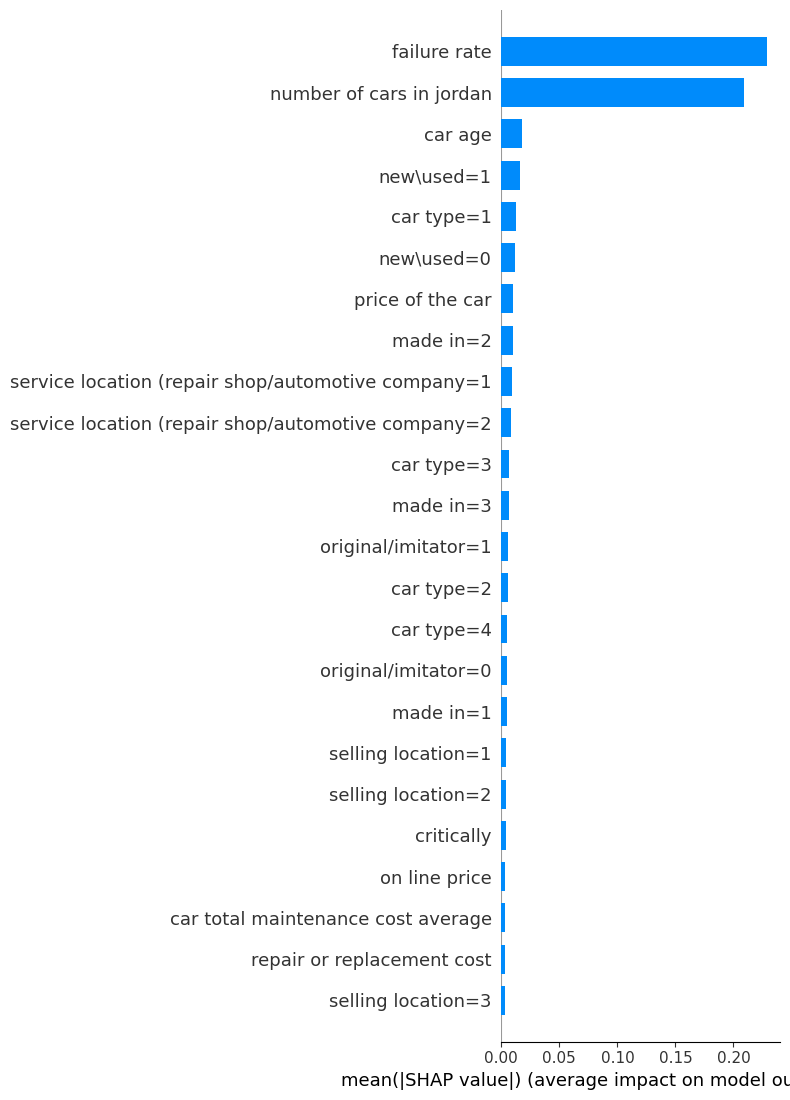

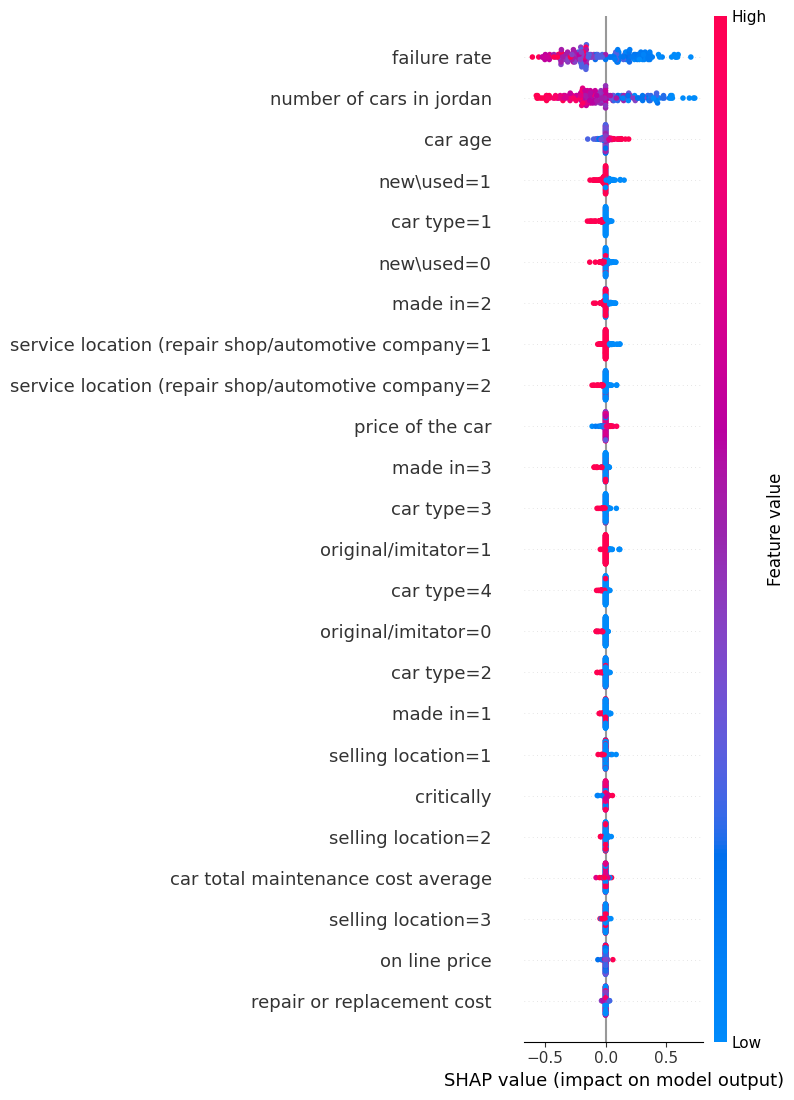

Displayed SHAP beeswarm plot for low_demand; top features listed above (not saved).


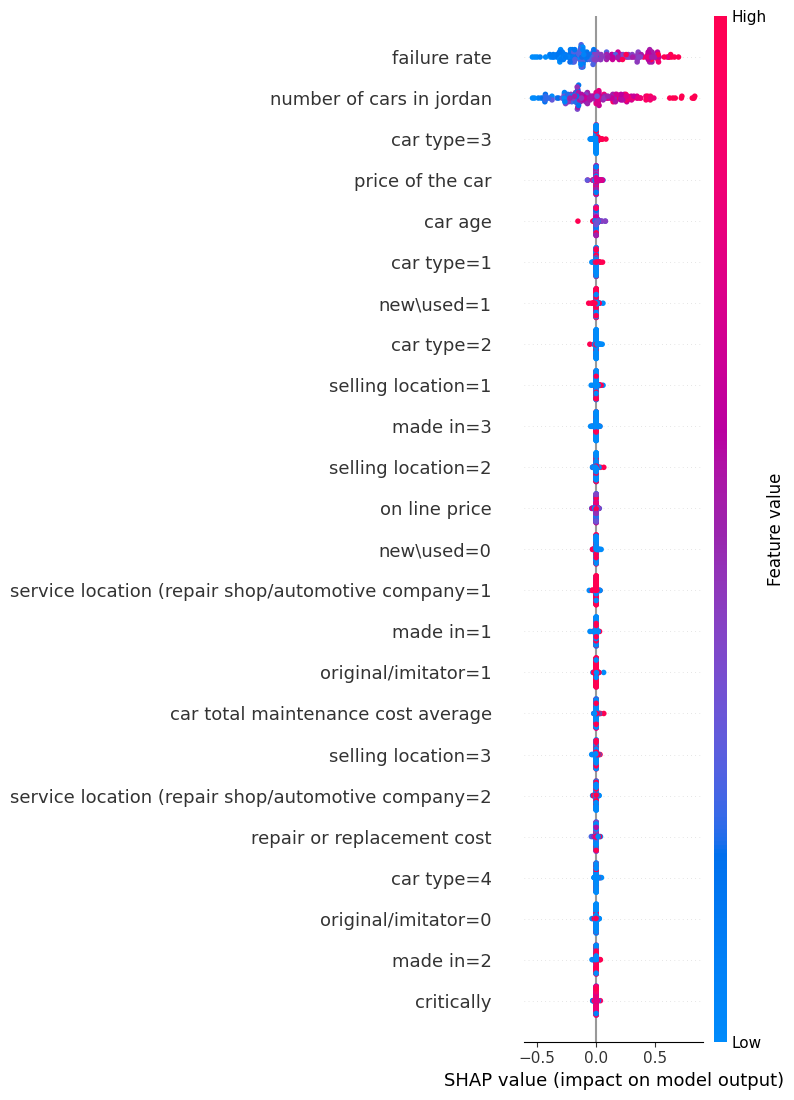

Displayed SHAP beeswarm plot for high_demand; top features listed above (not saved).
Displayed SHAP summary plot and feature importance details in notebook (no files saved).


In [23]:
# Generate summary plots and export top feature importances
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sv_raw = _shap_values
X_explain = _X_explain.toarray() if hasattr(_X_explain, 'toarray') else _X_explain

if isinstance(sv_raw, list):
    shap_array = np.stack([np.array(s) for s in sv_raw], axis=-1)
else:
    shap_array = np.array(sv_raw)
    if shap_array.ndim == 2:
        shap_array = shap_array[..., np.newaxis]

_shap_array = shap_array  # cache full tensor for later use
shap_abs = np.abs(shap_array).mean(axis=-1)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_abs, X_explain, feature_names=feature_names, plot_type='bar', show=False, max_display=25)
plt.tight_layout()
# plt.savefig('shap_summary_bar.png', dpi=300, bbox_inches='tight')
plt.show()

class_order = globals().get('class_order', list(range(shap_array.shape[-1])))
class_indices = {cls: idx for idx, cls in enumerate(class_order) if idx < shap_array.shape[-1]}
target_classes = {
    'low_demand': 0,
    'high_demand': 2,
}

for label, cls_id in target_classes.items():
    if cls_id not in class_indices:
        continue
    cls_idx = class_indices[cls_id]
    shap_class = shap_array[..., cls_idx]

    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_class, X_explain, feature_names=feature_names, show=False, max_display=25)
    plt.tight_layout()
    # plt.savefig(f'shap_beeswarm_{label}.png', dpi=300, bbox_inches='tight')
    plt.show()

    vals_cls = np.abs(shap_class).mean(axis=0)
    fi_cls = pd.Series(vals_cls, index=feature_names).sort_values(ascending=False)
    # fi_cls.head(20).to_csv(f'shap_feature_importance_{label}_top20.csv')
    print(f'Displayed SHAP beeswarm plot for {label}; top features listed above (not saved).')

vals = shap_abs.mean(axis=0)
fi = pd.Series(vals, index=feature_names).sort_values(ascending=False)
# fi.head(20).to_csv('shap_feature_importance_top20.csv')
print('Displayed SHAP summary plot and feature importance details in notebook (no files saved).')